In [3]:
from datasets import load_dataset
import time

### Load Datasets

Load a collection AI research arxiv papers from hugging face. The papers have been chunked and information (chunk id with arxiv id, paper title, chunk text, post chunk id and arxiv id from reference papaer) from each chunk is provided in a dictionary.

In [4]:
dataset = load_dataset("jamescalam/ai-arxiv2-semantic-chunks", split="train")

### Semantic Router

Semantic Router is a superfast decision-making layer for your LLMs and agents. 

https://github.com/aurelio-labs/semantic-router


In [66]:
import os
from getpass import getpass
from semantic_router.encoders import OpenAIEncoder
from langchain_core.agents import AgentAction, AgentFinish
from settings import config
pinecone_api_key = config["pinecone_api_key"]
serpapi_key=config["serpapi_key"]

In [6]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") or getpass("OpenAI API key: ")

In [7]:
encoder = OpenAIEncoder(name="text-embedding-3-small")

In [22]:
type(encoder)

semantic_router.encoders.openai.OpenAIEncoder

In [8]:
from pinecone import Pinecone
from pinecone import ServerlessSpec

In [9]:
pc = Pinecone(api_key=pinecone_api_key)

In [10]:
spec = ServerlessSpec(cloud="aws", region="us-east-1")

In [11]:
index_name = "gpt-4o-research-agent"
if index_name not in pc.list_indexes().names():
    # if it doesn't exist, create index
    pc.create_index(
        index_name,
        dimension=1536, # the length of the vector generated by the encoder above. 
        metric='dotproduct',
        spec=spec
    )
    # wait for index to be initiated
    while not pc.describe_index(index_name).status["ready"]:
        time.sleep(1)

In [12]:
index = pc.Index(index_name)
time.sleep(1)
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 1000}},
 'total_vector_count': 1000}

In [23]:
type(index)

pinecone.data.index.Index

In [24]:
from tqdm.auto import tqdm

In [25]:
data = dataset.to_pandas().iloc[:1000]

In [27]:
data

,id,title,content,prechunk_id,postchunk_id,arxiv_id,references
0,2401.04088#0,Mixtral of Experts,4 2 0 2 n a J 8 ] G L . s c [ 1 v 8 8 0 4 0 . ...,,2401.04088#1,2401.04088,[1905.07830]
1,2401.04088#1,Mixtral of Experts,Code: https://github.com/mistralai/mistral-src...,2401.04088#0,2401.04088#2,2401.04088,[1905.07830]
2,2401.04088#2,Mixtral of Experts,expertsâ ) to process the token and combine th...,2401.04088#1,2401.04088#3,2401.04088,[1905.07830]
3,2401.04088#3,Mixtral of Experts,"Instruct, a chat model fine-tuned to follow in...",2401.04088#2,2401.04088#4,2401.04088,[1905.07830]
4,2401.04088#4,Mixtral of Experts,# 2 Architectural details Mixtral is based on ...,2401.04088#3,2401.04088#5,2401.04088,[1905.07830]
...,...,...,...,...,...,...,...
995,2310.12773#64,Safe RLHF: Safe Reinforcement Learning from Hu...,"16 10. Misinformation Regarding Ethics, Laws, ...",2310.12773#63,2310.12773#65,2310.12773,[2302.13971]
996,2310.12773#65,Safe RLHF: Safe Reinforcement Learning from Hu...,Should ambiguities or questions arise during t...,2310.12773#64,2310.12773#66,2310.12773,[2302.13971]
997,2310.12773#66,Safe RLHF: Safe Reinforcement Learning from Hu...,# B IMPLEMENTATION DETAILS B.1 PREFERENCE MODE...,2310.12773#65,2310.12773#67,2310.12773,[2302.13971]
998,2310.12773#67,Safe RLHF: Safe Reinforcement Learning from Hu...,"LR(Â¢: Dr) = â Eve,yw,y)~Dr log o(Ro(Yw, 2%) â...",2310.12773#66,2310.12773#68,2310.12773,[2302.13971]


In [26]:
list(data['references'][0])

['1905.07830']

In [16]:
batch_size = 128
for i in tqdm(range(0, len(data), batch_size)):
    i_end = min(len(data), i+batch_size)
    batch = data[i:i_end].to_dict(orient="records")
    #get batch data
    metadata = [{
        "title": r["title"],
        "content": r["content"],
        "arxiv_id": r["arxiv_id"],
        "references": list(r["references"])
    } for r in batch]
    # generate unique ids for each chunk
    ids = [r["id"] for r in batch]
    content = [r["content"] for r in batch]
    #embed text
    embeds = encoder(content)
    # add to Pinecone
    index.upsert(vectors=zip(ids, embeds, metadata))

  0%|          | 0/8 [00:00<?, ?it/s]

In [28]:
import requests
arxiv_id = "2401.04088"
res = requests.get(f"https://export.arxiv.org/abs/{arxiv_id}") = requests.get(f"https://export.arxiv.org/abs/{arxiv_id}")


### Extract the abstract ftom a paper

In [29]:
import re
abstract_pattern = re.compile(
    r'<blockquote class="abstract mathjax">\s*<span class="descriptor">Abstract:</span>\s*(.*?)\s*</blockquote>',
    re.DOTALL
)

re_match = abstract_pattern.search(res.text)

print(re_match.group(1))


We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model. Mixtral has the same architecture as Mistral 7B, with the difference that each layer is composed of 8 feedforward blocks (i.e. experts). For every token, at each layer, a router network selects two experts to process the current state and combine their outputs. Even though each token only sees two experts, the selected experts can be different at each timestep. As a result, each token has access to 47B parameters, but only uses 13B active parameters during inference. Mixtral was trained with a context size of 32k tokens and it outperforms or matches Llama 2 70B and GPT-3.5 across all evaluated benchmarks. In particular, Mixtral vastly outperforms Llama 2 70B on mathematics, code generation, and multilingual benchmarks. We also provide a model fine-tuned to follow instructions, Mixtral 8x7B - Instruct, that surpasses GPT-3.5 Turbo, Claude-2.1, Gemini Pro, and Llama 2 70B - chat model on human benchmarks. Both 

### Perform a simple search using serpapi

In [21]:
from serpapi import GoogleSearch
# https://serpapi.com/manage-api-key
serpapi_params = {
    "engine": "google",
    "api_key": serpapi_key
}

search = GoogleSearch({
    **serpapi_params,
    "q": "coffee"
})

results = search.get_dict()["organic_results"]
contexts = "\n---\n".join(
    ["\n".join([x["title"], x["snippet"], x["link"]]) for x in results]
)
print(contexts)

Coffee
Coffee is a beverage brewed from roasted, ground coffee beans. Darkly colored, bitter, and slightly acidic, coffee has a stimulating effect on humans
https://en.wikipedia.org/wiki/Coffee
---
Starbucks Coffee Company
More than just great coffee. Explore the menu, sign up for Starbucks® Rewards, manage your gift card and more.
https://www.starbucks.com/
---
r/Coffee
thread where you can share what you are brewing or ask for bean recommendations. This is a place to share and talk about your favorite coffee roasters or beans.
https://www.reddit.com/r/Coffee/
---
Coffee
Shop Dunkin'® coffee, Folgers® coffee, Café Bustelo® coffee, and more. No matter how you like your coffee, we've got you covered! Choose from subtle to bold ...
https://shop.smucker.com/collections/coffee?srsltid=AfmBOor5gqPO7OO9zc7mlXq6vddgEaioHlD9fp3TExGhPxKExpjsYFxq
---
Catalina Coffee: Order Online - Houston
Catalina Coffee 2201 Washington Ave Houston, Texas 77007 (713) 861-8448 info@catalinacoffeeshop.com Get dir

In [45]:
from serpapi import GoogleSearch
from langchain_core.tools import tool
from utils import format_rag_contexts
from semantic_router.encoders import OpenAIEncoder

@tool("fetch_arxiv")
def fetch_arxiv(arxiv_id: str):
    """Gets the abstract from an ArXiv paper given the arxiv ID.
    Useful for finding high-level context about a specific paper.
    """
    res = requests.get(
        f"https://export.arxiv.org/abs/{arxiv_id}"
    )
    re_match = abstract_pattern.search(res.text)
    return re_match.group(1)

print(
    fetch_arxiv.invoke(input={"arxiv_id": arxiv_id})
)


@tool("web_search")
def web_search(query: str, serpapi_params: dict):
    """Finds general knowledge information using Google Search. Can
    also be used to augment 'general' knowledge to a previous
    specialist query
    """
    search = GoogleSearch({
        **serpapi_params,
        "q": query,
        "num": 5,
    })
    results = search.get_dict()["organic_results"]
    contexts = "\n---\n".join(
        ["\n".join([x["title"], x["snippet"], x["link"]]) for x in results]
    )
    return contexts




We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model. Mixtral has the same architecture as Mistral 7B, with the difference that each layer is composed of 8 feedforward blocks (i.e. experts). For every token, at each layer, a router network selects two experts to process the current state and combine their outputs. Even though each token only sees two experts, the selected experts can be different at each timestep. As a result, each token has access to 47B parameters, but only uses 13B active parameters during inference. Mixtral was trained with a context size of 32k tokens and it outperforms or matches Llama 2 70B and GPT-3.5 across all evaluated benchmarks. In particular, Mixtral vastly outperforms Llama 2 70B on mathematics, code generation, and multilingual benchmarks. We also provide a model fine-tuned to follow instructions, Mixtral 8x7B - Instruct, that surpasses GPT-3.5 Turbo, Claude-2.1, Gemini Pro, and Llama 2 70B - chat model on human benchmarks. Both 

In [46]:
@tool("rag_search_filter")
def rag_search_filter(query: str, arxiv_id: str, encoder, index):
    """Finds information from our ArXiv database using a natural
    language query and a specific ArXiv ID. Allows us to learn
    more details about a specific paper.
    """
    xq = encoder([query])
    xc = index.query(vector=xq, top_k=6, include_metadata=True,
                     filter={"arxiv_id": arxiv_id})
    context_str = format_rag_contexts(xc["matches"])
    return context_str




In [47]:
@tool("rag_search")
def rag_search(query: str, encoder, index):
    """Finds specialist information on AI using natural language query."""
    xq = encoder([query])
    xc = index.query(vector=xq, top_k=2, include_metadata=True)
    context_str = format_rag_contexts(xc["matches"])
    return context_str


@tool("final_answer")
def final_answer(
        introduction: str,
        research_steps: str,
        main_body: str,
        conclusion: str,
        sources: str
):
    """Return a natural language response to the user in the form
    of a research report. There are several sections to this report,
    those are:
    - `introduction`: a short paragraph introducing the user's questions
    and the topic we are researching.
    - `research_steps`: a few bullet points explaining the steps that were
    taken to research your report
    - `main_body`: this is where the bulk of high quality and concise
    information that answer the user's question belongs. It is 3-4
    paragraphs long in length.
    - `conclusion`: this is a short single paragraph conclusion providing a
    concise but sophisticated view on what was found.
    - `sources`: a bulletpoint list provided detailed sources for all
    information referenced during the research process
    """
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    if type(sources) in list:
        sources = "\n".join([f"- {s}" for s in sources])
    return ""

### Initialize the Oracle
The Oracle LLM is our graph decision maker. It decides which path we should take down our graph. It functions similarly to an agent but is much simpler and reliable.


In [48]:
from prompts import prompt

In [49]:
from langchain_core.messages import ToolCall, ToolMessage
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o",
    openai_api_key=os.environ["OPENAI_API_KEY"],
    temperature=0
)

In [50]:
tools = [
    rag_search_filter,
    rag_search,
    fetch_arxiv,
    web_search,
    final_answer
]


In [67]:
# Define a function to transform intermediate steps from list of agentAction to scratchpad string

def create_scratchpad(intermediate_steps: list[AgentAction]):
    research_steps = []
    for i, action in enumerate(intermediate_steps):
        if action.log != "TBD":
            #this was the ToolExecution
            research_steps.append(
                f"Tool: {action.tool}, input: {action.tool_input}\n"
                f"Output: {action.log}"
            )
    return "\n---\n".join(research_steps)

In [68]:
oracle = (
    {
        "input": lambda x: x["input"],
        "chat_history": lambda x: x["chat_history"],
        "scratchpad": lambda x: create_scratchpad(intermediate_steps=x["intermediate_steps"])
    }
    | prompt
    | llm.bind_tools(tools, tool_choice="any")


)

### Define Nodes for Graph

We will be passing the tool use decision to our router which will route the output to the chose node component to run based on the out.tool_calls[0]["name"] value

In [57]:
def run_oracle(state: list):
    print("run oracle")
    print(f"intermediate_steps: {state['intermediate_steps']}")
    out = oracle.invoke(state)
    tool_name = out.tool_calls[0]["name"]
    tool_args = out.tool_calls[0]["args"]
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log="TBD"
    )
    return {
        "intermediate_steps": [action_out]
    }

In [53]:
def router(state: list):
    if ininstance(state["intermediate_steps"], list):
        return state["intermediate_steps"][-1].tool
    else:
        print("Router invalid format")
        return "final_answer"

In [58]:
tool_str_to_funct = {
    "rag_search_filter": rag_search_filter,
    "rag_search": rag_search,
    "fetch_arxiv": fetch_arxiv,
    "web_search": web_search,
    "final_answer": final_answer
}

In [59]:
def run_tool(state: list):
    tool_name = state["intermediate_steps"][-1].tool
    tool_args = state["intermediate_steps"][-1].tool_input
    print(f"{tool_name}.invoke(input={tool_args})")
    # run tool
    out = tool_str_to_funct[tool_name].invoke(input=tool_args)
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log=str(out)
    )


## Define Graph

In [60]:
from langgraph.graph import StateGraph, END
from states import AgentState


graph = StateGraph(AgentState)

graph.add_node("oracle", run_oracle)
graph.add_node("rag_search_filter", run_tool)
graph.add_node("rag_search", run_tool)
graph.add_node("fetch_arxiv", run_tool)
graph.add_node("web_search", run_tool)
graph.add_node("final_answer", run_tool)


In [61]:
graph.add_conditional_edges(
    source="oracle", # where in graph to start
    path=router, # function to determine which node is called
)


In [62]:
for tool_obj in tools:
    if tool_obj.name != "final_answer":
        graph.add_edge(tool_obj.name, "oracle")

In [63]:
graph.add_edge("final_answer", END)
runnable = graph.compile()

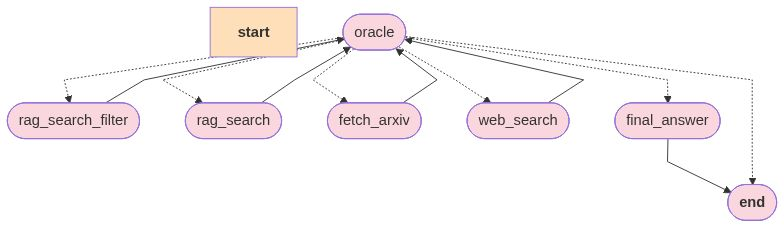

In [64]:
from IPython.display import Image, display
display(Image(runnable.get_graph().draw_mermaid_png()))